# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [33]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

In [34]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [35]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [36]:
remove_cols= function(l, cols){
    return(l[! l %in% cols])
}

In [37]:
make_factors = function(model_data){
model_data$Structure1 = as.factor(model_data$Structure1)
model_data$Pipe_Geome = as.factor(model_data$Pipe_Geome)
model_data$Pipe_Mater = as.factor(model_data$Pipe_Mater)
model_data$Condition = as.factor(model_data$Condition)
return(model_data)
}

In [38]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_Data/"
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [39]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [83]:
test_df = dbReadTable(con, 'test_geog_data_hg')
train_df = dbReadTable(con, 'train_geog_data_hg')

In [84]:
colnames(test_df)


[1] "level_0"      "AWDR.19"      "AWND.19"      "AWND.20"      "WDF2.19"     
  [6] "WDF2.20"      "WDF2.3"       "WDF6.18"      "WGF6.18"      "WSF2.19"     
 [11] "WSF2.20"      "WSF2.3"       "WSF6.18"      "event_name"   "flooded"     
 [16] "gw_av.10"     "gw_av.11"     "gw_av.4"      "gw_av.5"      "gw_av.6"     
 [21] "gw_av.8"      "gw_av.9"      "hht.17"       "hht.18"       "ht.17"       
 [26] "ht.18"        "llt.17"       "llt.18"       "lt.17"        "lt.18"       
 [31] "num_flooded"  "r15.11_td.17" "r15.11_td.18" "r15.12_td.17" "r15.12_td.18"
 [36] "r15.13_td.17" "r15.13_td.18" "r15.14_td.17" "r15.14_td.18" "r15.15_td.17"
 [41] "r15.15_td.18" "r15.16_td.17" "r15.16_td.18" "r15.1_td.17"  "r15.1_td.18" 
 [46] "r15.21_td.17" "r15.21_td.18" "r15.2_td.17"  "r15.2_td.18"  "r15.7_td.17" 
 [51] "r15.7_td.18"  "r15mx.1"      "r15mx.11"     "r15mx.12"     "r15mx.13"    
 [56] "r15mx.14"     "r15mx.15"     "r15mx.16"     "r15mx.2"      "r15mx.21"    
 [61] "r15mx.7"      "r3d.1"        "r3d.11"       "r3d.12"       "r3d.13"      
 [66] "r3d.14"       "r3d.15"       "r3d.16"       "r3d.19"       "r3d.2"       
 [71] "r3d.20"       "r3d.21"       "r3d.7"        "rd.1"         "rd.11"       
 [76] "rd.12"        "rd.13"        "rd.14"        "rd.15"        "rd.16"       
 [81] "rd.19"        "rd.2"         "rd.20"        "rd.21"        "rd.7"        
 [86] "rhr.11_td.17" "rhr.11_td.18" "rhr.12_td.17" "rhr.12_td.18" "rhr.13_td.17"
 [91] "rhr.13_td.18" "rhr.14_td.17" "rhr.14_td.18" "rhr.15_td.17" "rhr.15_td.18"
 [96] "rhr.16_td.17" "rhr.16_td.18" "rhr.1_td.17"  "rhr.1_td.18"  "rhr.21_td.17"
[101] "rhr.21_td.18" "rhr.2_td.17"  "rhr.2_td.18"  "rhr.7_td.17"  "rhr.7_td.18" 
[106] "rhrmx.1"      "rhrmx.11"     "rhrmx.12"     "rhrmx.13"     "rhrmx.14"    
[111] "rhrmx.15"     "rhrmx.16"     "rhrmx.2"      "rhrmx.21"     "rhrmx.7"     
[116] "td_av.17"     "td_av.18"     "index"        "location"     "xcoord"      
[121] "ycoord"       "count"        "twi"          "elev_1"       "dist_to_ba"  
[126] "imp"          "dist_to_wa"   "is_dntn"      "in_hague"     "Structure1"  
[131] "Rim_Elevat"   "Invert_Ele"   "Year_Insta"   "Pipe_Geome"   "Horizontal"  
[136] "Vertical_D"   "Pipe_Lengt"   "Pipe_Mater"   "Year_Ins_1"   "Condition"   
[141] "flood_pt"

In [85]:
cols_to_remove = c('level_0', 'index', 'is_dntn', 'flood_pt', 'event_name', 'num_flooded', 'location', 'count', 'flooded')
in_col_names = remove_cols(colnames(test_df), cols_to_remove)
out_col_name = 'flooded'

In [86]:
test_df = make_factors(test_df)
train_df = make_factors(train_df)

In [87]:
train_data = train_df[, append(in_col_names, out_col_name)]
test_data = test_df[, append(in_col_names, out_col_name)]

In [88]:
train_in_data = train_df[, in_col_names]
test_in_data = test_df[, in_col_names]

In [89]:
tst_out = test_df[, out_col_name]
trn_out = train_df[, out_col_name]

### Scale data

In [18]:
train_col_stds = apply(train_in_data, 2, sd)
train_col_means = colMeans(train_in_data)

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"NAs introduced by coercion"

ERROR: Error in colMeans(train_in_data): 'x' must be numeric


In [ ]:
train_normalized = t((t(train_in_data)-train_col_means)/train_col_stds)
test_normalized = t((t(test_in_data)-train_col_means)/train_col_stds)

### PCA transform

In [ ]:
pca = prcomp(train_normalized)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=model_data[train_ind, out_col_name], label=rownames(pca$x)))
p + geom_point() + geom_text()
print(pca)
plot(pca)

In [ ]:
trn_preprocessed = predict(pca, train_normalized)
tst_preprocessed = predict(pca, test_normalized)
trn_in = trn_preprocessed
tst_in = tst_preprocessed

In [ ]:
train_data = cbind(as.data.frame(trn_in), flooded = model_data[train_ind, out_col_name])
fmla = as.formula(paste(out_col_name, "~", paste(colnames(trn_in), collapse="+")))
fmla

### KNN

In [ ]:
kfit = knn(trn_in, tst_in, trn_out, k=5)
table(tst_out, kfit)

### SVM

In [ ]:
svm_fit = svm(fmla, data=train_data)
svm_pred = predict(svm_fit, tst_in)
table(tst_out, svm_pred)

### Decision Trees

In [90]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))

In [91]:
colnames(train_data)

[1] "AWDR.19"      "AWND.19"      "AWND.20"      "WDF2.19"      "WDF2.20"     
  [6] "WDF2.3"       "WDF6.18"      "WGF6.18"      "WSF2.19"      "WSF2.20"     
 [11] "WSF2.3"       "WSF6.18"      "gw_av.10"     "gw_av.11"     "gw_av.4"     
 [16] "gw_av.5"      "gw_av.6"      "gw_av.8"      "gw_av.9"      "hht.17"      
 [21] "hht.18"       "ht.17"        "ht.18"        "llt.17"       "llt.18"      
 [26] "lt.17"        "lt.18"        "r15.11_td.17" "r15.11_td.18" "r15.12_td.17"
 [31] "r15.12_td.18" "r15.13_td.17" "r15.13_td.18" "r15.14_td.17" "r15.14_td.18"
 [36] "r15.15_td.17" "r15.15_td.18" "r15.16_td.17" "r15.16_td.18" "r15.1_td.17" 
 [41] "r15.1_td.18"  "r15.21_td.17" "r15.21_td.18" "r15.2_td.17"  "r15.2_td.18" 
 [46] "r15.7_td.17"  "r15.7_td.18"  "r15mx.1"      "r15mx.11"     "r15mx.12"    
 [51] "r15mx.13"     "r15mx.14"     "r15mx.15"     "r15mx.16"     "r15mx.2"     
 [56] "r15mx.21"     "r15mx.7"      "r3d.1"        "r3d.11"       "r3d.12"      
 [61] "r3d.13"       "r3d.14"       "r3d.15"       "r3d.16"       "r3d.19"      
 [66] "r3d.2"        "r3d.20"       "r3d.21"       "r3d.7"        "rd.1"        
 [71] "rd.11"        "rd.12"        "rd.13"        "rd.14"        "rd.15"       
 [76] "rd.16"        "rd.19"        "rd.2"         "rd.20"        "rd.21"       
 [81] "rd.7"         "rhr.11_td.17" "rhr.11_td.18" "rhr.12_td.17" "rhr.12_td.18"
 [86] "rhr.13_td.17" "rhr.13_td.18" "rhr.14_td.17" "rhr.14_td.18" "rhr.15_td.17"
 [91] "rhr.15_td.18" "rhr.16_td.17" "rhr.16_td.18" "rhr.1_td.17"  "rhr.1_td.18" 
 [96] "rhr.21_td.17" "rhr.21_td.18" "rhr.2_td.17"  "rhr.2_td.18"  "rhr.7_td.17" 
[101] "rhr.7_td.18"  "rhrmx.1"      "rhrmx.11"     "rhrmx.12"     "rhrmx.13"    
[106] "rhrmx.14"     "rhrmx.15"     "rhrmx.16"     "rhrmx.2"      "rhrmx.21"    
[111] "rhrmx.7"      "td_av.17"     "td_av.18"     "xcoord"       "ycoord"      
[116] "twi"          "elev_1"       "dist_to_ba"   "imp"          "dist_to_wa"  
[121] "in_hague"     "Structure1"   "Rim_Elevat"   "Invert_Ele"   "Year_Insta"  
[126] "Pipe_Geome"   "Horizontal"   "Vertical_D"   "Pipe_Lengt"   "Pipe_Mater"  
[131] "Year_Ins_1"   "Condition"    "flooded"

In [92]:
fit = rpart(dt_fmla, method='class', data=train_data, minsplit=1, minbucket=1)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = train_data, method = "class", 
    minsplit = 1, minbucket = 1)

Variables actually used in tree construction:
 [1] AWDR.19    dist_to_wa elev_1     Horizontal r15mx.15   rd.15     
 [7] rd.16      rd.2       rd.20      rd.21      rhrmx.2    twi       
[13] WDF2.3    

Root node error: 73/18015 = 0.0040522

n= 18015 

        CP nsplit rel error  xerror     xstd
1 0.232877      0  1.000000 1.00000 0.116804
2 0.082192      2  0.534247 0.53425 0.085455
3 0.054795      4  0.369863 0.42466 0.076205
4 0.022831      5  0.315068 0.32877 0.067065
5 0.013699      9  0.191781 0.30137 0.064213
6 0.010000     17  0.082192 0.38356 0.072430


png 
  2

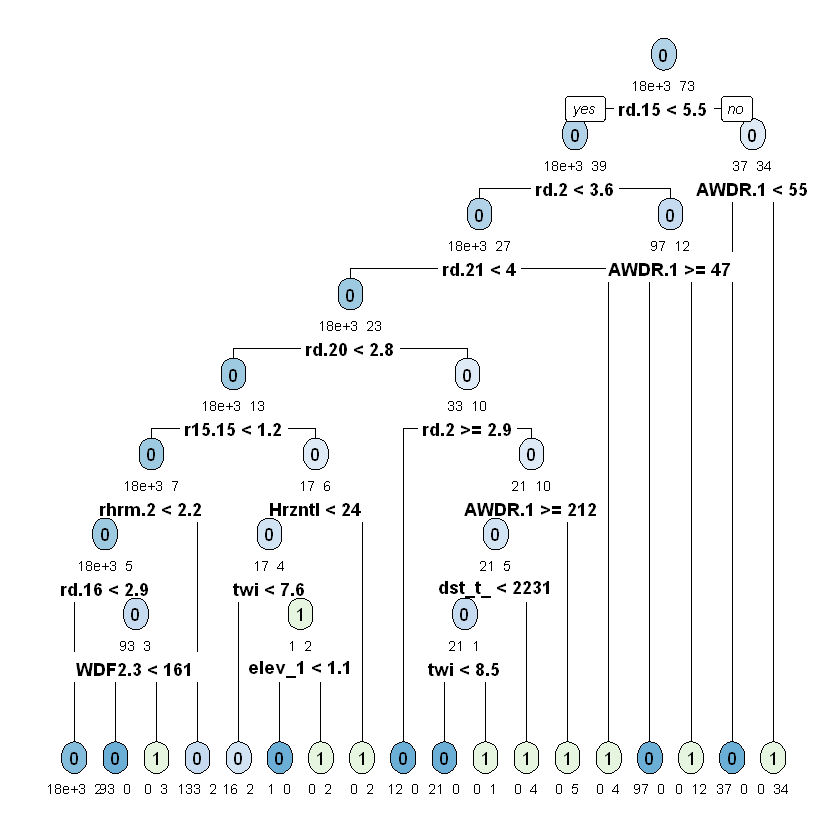

In [93]:
tiff(paste(fig_dir, "Plot_hg.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

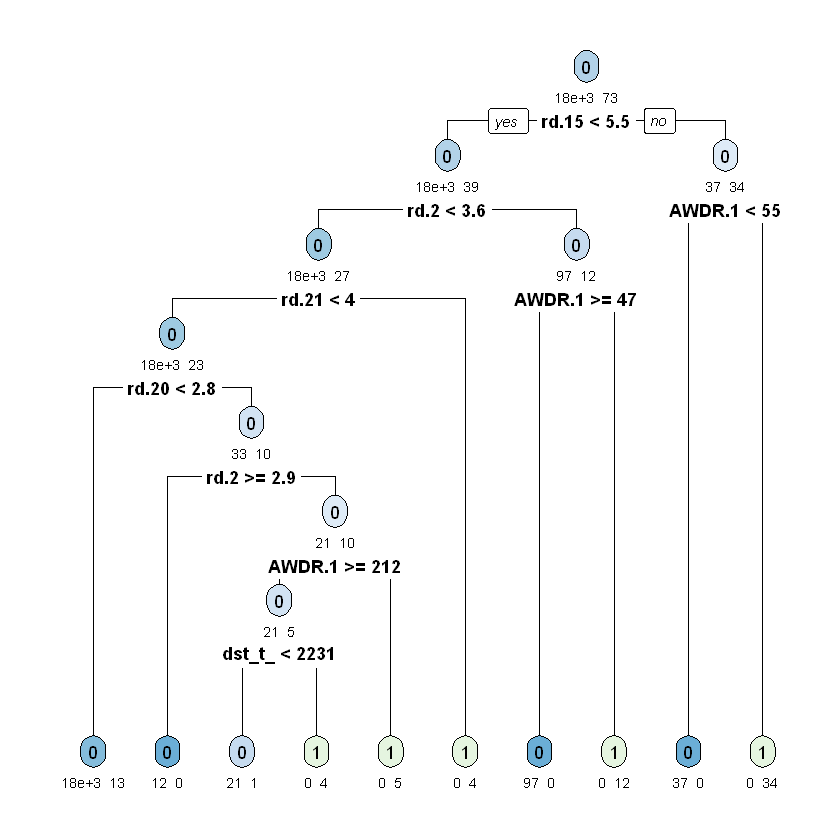

In [94]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [95]:
pred = predict(pfit, train_data, type = 'class')
table(trn_out, pred)

       pred
trn_out     0     1
      0 17942     0
      1    14    59

#### Decision Tree testing results

In [96]:
pred = predict(pfit, test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out    0    1
      0 7691    0
      1   12   19

### Random Forests

In [78]:
forest = randomForest(dt_fmla, data = dt_train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, dt_train_data[, in_col_names])
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   741    0
  TRUE      0   82

       pred
tst_out FALSE  TRUE
  FALSE 52476   506
  TRUE      8    27

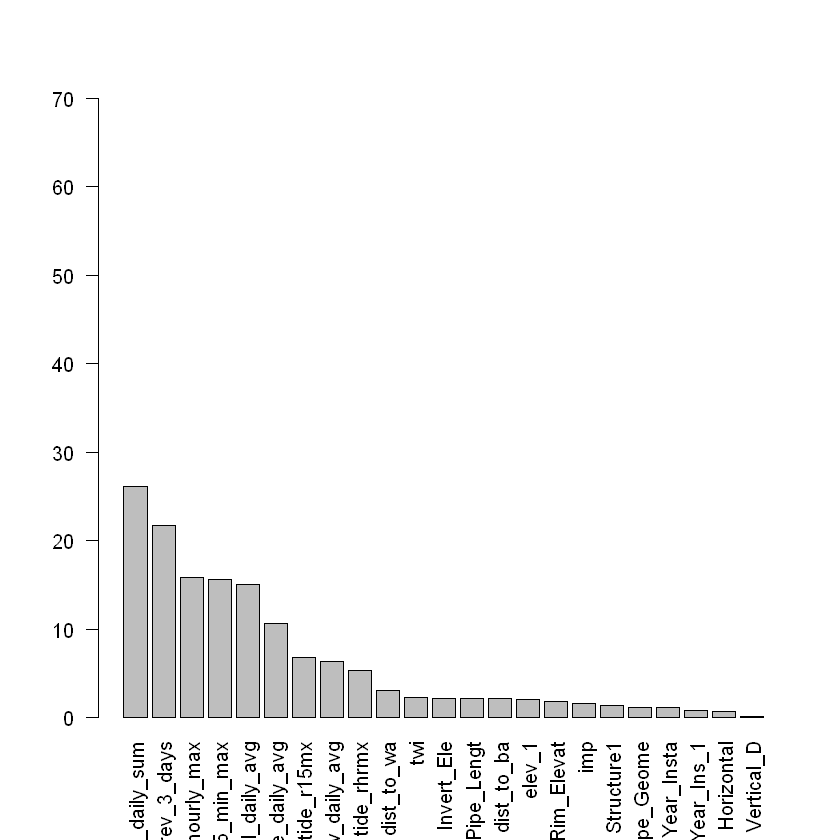

In [79]:
pred = predict(forest, dt_test_data)
table(tst_out, pred)
impo = as.data.frame(forest$importance)
impo = impo[order(-impo$MeanDecreaseGini),]
par(las=2)
barplot(impo$MeanDecreaseGini, names.arg=rownames(impo), ylim = c(0, 70))

### Logistic Regression

In [ ]:
lo_fit = glm(fmla, family=binomial(link='logit'), data=train_data)
print(lo_fit)

In [ ]:
pred = predict(lo_fit, as.data.frame(tst_in), type="response")
table(tst_out, round(pred)>0)